In [615]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium  
from folium.plugins import MarkerCluster
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from branca.colormap import linear
from branca.element import Figure

# <font color='Red'><p style="font-size: 40px;"><b>Police Shooting Analysis</b></p>

## "Today, we're diving into a subject about police incidents in the USA. Our goal is simple: figure out what's happening in these situations, especially looking at who's involved and how body cameras might play a role. Let's break it down together and see what insights we can find about policing practices and accountability."

## "Dataset Overview"

In [616]:
#Cleaning and Setting the Data for the Analysis
police_data = pd.read_csv('Datas/USA_Police.csv', index_col=0)
police_data = police_data.rename(str.capitalize, axis='columns')
police_data = police_data.rename(columns={"Name": "Victim"})

In [617]:
police_data.head(10)

,Victim,Date,Manner_of_death,Armed,Age,Gender,Race,City,State,Signs_of_mental_illness,Threat_level,Flee,Body_camera
id,,,,,,,,,,,,,
3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False
11,Kenneth Joe Brown,2015-01-04,shot,gun,18.0,M,W,Guthrie,OK,False,attack,Not fleeing,False
13,Kenneth Arnold Buck,2015-01-05,shot,gun,22.0,M,H,Chandler,AZ,False,attack,Car,False
15,Brock Nichols,2015-01-06,shot,gun,35.0,M,W,Assaria,KS,False,attack,Not fleeing,False
16,Autumn Steele,2015-01-06,shot,unarmed,34.0,F,W,Burlington,IA,False,other,Not fleeing,True


### 
- <b>Source:</b> Our dataset is directly from The Washington Post, ensuring credibility.
- <b>Attributes:</b> Each incident is detailed by victim, date, manner of death, weapon, age, gender, race, city, and state.
- <b>Relevance:</b> These details are crucial for uncovering patterns related to demographics and body camera influence.
- <b>Demographics:</b> We have age, gender, and race information, laying the foundation for understanding individuals involved.
- <b>Geographical Context:</b> City and state details allow exploration of potential regional variations.
- <b>Mental Illness:</b> An indicator provides insights into the mental health aspect of individuals.
- <b>Threat and Fleeing Details:</b> Information about threat levels and fleeing adds context to each situation.
- <b>Body Camera Indicator:</b> Crucially, we note whether body cameras were in use during each incident. We'll analyze the distribution of incidents with and without body cameras, exploring correlations.

## "Cleaning Process & Settings"

### % Of NaN Values

In [619]:
na_count = police_data.isna().sum()
na_percentage = (na_count / len(police_data)) * 100

na_summary = pd.DataFrame({
    'NA Count': na_count,
    'NA Percentage': na_percentage
})
na_summary

,NA Count,NA Percentage
Victim,19,0.887021
Date,0,0.000000
Manner_of_death,0,0.000000
Armed,6,0.280112
Age,43,2.007470
Gender,1,0.046685
Race,103,4.808590
City,0,0.000000
State,0,0.000000
Signs_of_mental_illness,0,0.000000


### Imputation Technique using k-Nearest Neighbors (KNN) for numerical values

In [620]:
# Mainly used for Age
numerical_columns = police_data.select_dtypes(include=['number']).columns
df_numeric = police_data[numerical_columns]

knn_imputer = KNNImputer(n_neighbors=3)

police_data_imputed = knn_imputer.fit_transform(df_numeric)

police_data[numerical_columns] = police_data_imputed

### Imputation Technique with mode (Most frequent value) for categorical values

In [621]:
police_data['Race'].fillna(police_data['Race'].mode()[0], inplace=True)

### Imputation Technique with Specific Value for categorical values

In [622]:
police_data.loc[:, ['Victim', 'Armed', 'Flee']] = police_data[['Victim', 'Armed', 'Flee']].fillna('Unknown')

### Setting Race for Acronyms

In [623]:
race_mapping = {
    'A': 'Asian',
    'B': 'Black',
    'H': 'Hispanic',
    'W': 'White',
    'O': 'Other',
    'N': 'Native American',
}
police_data['Race'] = police_data['Race'].replace(race_mapping)

### Adding Region

In [624]:
df = pd.read_csv('Datas/states.csv')
state_region = df[['State Code', 'Region']]
police_data['Region'] = police_data['State'].map(state_region.set_index('State Code')['Region'])

### After Cleaning

In [625]:
police_data.isna().sum()

Victim                     0
Date                       0
Manner_of_death            0
Armed                      0
Age                        0
Gender                     1
Race                       0
City                       0
State                      0
Signs_of_mental_illness    0
Threat_level               0
Flee                       0
Body_camera                0
Region                     0
dtype: int64

### Describe

In [626]:
police_data.describe()

,Age
count,2142.000000
mean,36.484516
std,12.744063
min,6.000000
25%,27.000000
50%,35.000000
75%,45.000000
max,86.000000


## "Declaring Variables & Functions"

#### "State Coordinates"

In [627]:
state_coordinates = {
    'AL': [32.806671, -86.791130], 'AK': [61.370716, -152.404419],
    'AZ': [33.729759, -111.431221], 'AR': [34.969704, -92.373123],
    'CA': [36.116203, -119.681564], 'CO': [39.059811, -105.311104],
    'CT': [41.597782, -72.755371], 'DE': [39.318523, -75.507141],
    'FL': [27.766279, -81.686783], 'GA': [33.040619, -83.643074],
    'HI': [21.094318, -157.498337], 'ID': [44.240459, -114.478828],
    'IL': [40.349457, -88.986137], 'IN': [39.849426, -86.258278],
    'IA': [42.011539, -93.210526], 'KS': [38.526600, -96.726486],
    'KY': [37.668140, -84.670067], 'LA': [31.169546, -91.867805],
    'ME': [44.693947, -69.381927], 'MD': [39.063946, -76.802101],
    'MA': [42.230171, -71.530106], 'MI': [43.326618, -84.536095],
    'MN': [45.694454, -93.900192], 'MS': [32.741646, -89.678696],
    'MO': [38.456085, -92.288368], 'MT': [46.921925, -110.454353],
    'NE': [41.125370, -98.268082], 'NV': [38.313515, -117.055374],
    'NH': [43.452492, -71.563896], 'NJ': [40.298904, -74.521011],
    'NM': [34.840515, -106.248482], 'NY': [42.165726, -74.948051],
    'NC': [35.630066, -79.806419], 'ND': [47.528912, -99.784012],
    'OH': [40.388783, -82.764915], 'OK': [35.565342, -96.928917],
    'OR': [44.572021, -122.070938], 'PA': [40.590752, -77.209755],
    'RI': [41.680893, -71.511780], 'SC': [33.856892, -80.945007],
    'SD': [44.299782, -99.438828], 'TN': [35.747845, -86.692345],
    'TX': [31.054487, -97.563461], 'UT': [40.150032, -111.862434],
    'VT': [44.045876, -72.710686], 'VA': [37.769337, -78.169968],
    'WA': [47.400902, -121.490494], 'WV': [38.491226, -80.954067],
    'WI': [44.268543, -89.616508], 'WY': [42.755966, -107.302490],
}

#### "Latitude and Longitude for each city"

In [628]:
# Creating Dict with Latitude and Longitude for each city in Dataframe -> 'City':['Lat', 'Lng']
df = pd.read_csv('Datas/uscities.csv')
usa_cities = df[['city', 'lat', 'lng']]
my_cities = list(police_data['City'])

my_dict = {}

for index, row in usa_cities.iterrows():
    if row['city'] in my_cities:
        my_dict[row['city']] = [row['lat'], row['lng']]

#### "Seaborn Histplot"

In [629]:
def plot_histplot(dataframe, title: str, xlabel: str, ylabel: str) -> None:
    """
    Plots a histogram with kernel density estimate (KDE) using Seaborn.

    Parameters:
    - dataframe (pandas.DataFrame): The input DataFrame containing the data to be visualized.
    - title (str): The title of the plot.
    - xlabel (str): The label for the x-axis.
    - ylabel (str): The label for the y-axis.

    Returns:
    None

    Example:
    >>> plot_histplot(my_dataframe, 'Distribution of Values', 'X-axis Label', 'Y-axis Label')
    """
    sns.histplot(dataframe, bins=30, kde=True)
    sns.despine()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


#### "Seaborn Countplot"

In [630]:
def plot_countplot(x: str, dataframe, title: str, xlabel: str, ylabel: str, hue: str = None) -> None:
    """
    Plots a countplot using Seaborn to visualize the distribution of categorical data.

    Parameters:
    - x (str): The variable to be plotted on the x-axis.
    - dataframe (pandas.DataFrame): The input DataFrame containing the data to be visualized.
    - title (str): The title of the plot.
    - xlabel (str): The label for the x-axis.
    - ylabel (str): The label for the y-axis.
    - hue (str, optional): Variable in 'dataframe' to map plot aspects to different colors.
                           Default is None.

    Returns:
    None

    Example:
    >>> plot_countplot('Category', my_dataframe, 'Distribution of Categories', 'Categories', 'Count', hue='Group')
    """
    sns.countplot(x=x, data=dataframe, hue=hue)
    sns.despine()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


#### "Seaborn Barplot"

In [631]:
def plot_barplot(dataframe, title: str, xlabel: str, ylabel: str, orient: str='v') -> None:
    """
    Plots a barplot using Seaborn to visualize the distribution of data.

    Parameters:
    - dataframe (pandas.DataFrame): The input DataFrame containing the data to be visualized.
    - title (str): The title of the plot.
    - xlabel (str): The label for the x-axis.
    - ylabel (str): The label for the y-axis.
    - orient (str, optional): Orientation of the plot ('v' for vertical, 'h' for horizontal).
                             Default is 'v'.

    Returns:
    None

    Example:
    >>> plot_barplot(my_dataframe, 'Distribution of Values', 'Categories', 'Count', orient='h')
    """
    sns.barplot(data=dataframe, orient=orient)
    sns.despine()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


#### "Folium Map"

In [632]:
def folium_map_incidents(dataframe):
    """
    Generates a Folium map based on incident counts in U.S. states.

    Parameters:
    - dataframe (pandas.DataFrame): Input DataFrame containing state-level incident count data.

    Returns:
    folium.map.Figure: A Folium map embedded in a matplotlib Figure.

    Example:
    >>> incidents_df = pd.DataFrame({'State': ['California', 'Texas', 'New York'],
    ...                              'IncidentCount': [100, 50, 75]})
    >>> folium_map_incidents(incidents_df)
    """
    fig = Figure(width=800, height=400)
    mymap = folium.Map(location=[37.7749, -97.4194], zoom_start=4)

    min_count = dataframe['IncidentCount'].min()
    max_count = dataframe['IncidentCount'].max()

    colormap = linear.RdYlBu_09.scale(min_count, max_count)

    for index, row in dataframe.iterrows():
        state = row['State']
        incident_count = row['IncidentCount']

        coordinates = state_coordinates.get(state, (0, 0))

        color = colormap(incident_count)

        popup_text = f"State:{state} Incident Count:{incident_count}"

        folium.CircleMarker(location=coordinates, radius=10, color=color,
                            fill=True, fill_opacity=0.7, popup=popup_text).add_to(mymap)

    return fig.add_child(mymap)


#### "Normalized Folium Map"

In [633]:
def normalized_folium_map_incidents(dataframe, column):
    """
    Generates a normalized Folium map based on incident counts in U.S. states.

    Parameters:
    - dataframe (pandas.DataFrame): Input DataFrame containing state-level incident count data.
    - column (str): The column in the DataFrame to use for grouping and normalization.

    Returns:
    folium.map.Figure: A Folium map embedded in a matplotlib Figure.

    Example:
    >>> incidents_df = pd.DataFrame({'State': ['California', 'Texas', 'New York'],
    ...                              'IncidentCount': [100, 50, 75]})
    >>> normalized_folium_map_incidents(incidents_df, 'State')
    """
    # Grouping Filtered Data
    incident_counts = dataframe.groupby(
        by=column).size().reset_index(name='IncidentCount')

    # Normalize data
    incident_counts['Normalized'] = preprocessing.normalize(
        incident_counts[['IncidentCount']], axis=0)
    normalized_values = incident_counts['Normalized'].squeeze()

    # Setting Figure Size and Location in Folium Map
    fig = Figure(width=800, height=400)
    mymap = folium.Map(location=[37.7749, -97.4194], zoom_start=4)

    # Setting Color Scale
    colormap = linear.RdYlBu_09.scale(
        normalized_values.min(), normalized_values.max())

    # For each State Create Label on the Map
    for index, row in incident_counts.iterrows():
        state = row['State']
        normalized_count = row['Normalized']

        coordinates = state_coordinates.get(state, (0, 0))

        color = colormap(normalized_count)

        popup_text = f"State:{state} Incident Count:{normalized_count*100:.2f}%"

        folium.CircleMarker(location=coordinates, radius=10, color=color,
                            fill=True, fill_opacity=0.7, popup=popup_text).add_to(mymap)

    return fig.add_child(mymap)


## "Demographic Overview"

### "By Age"

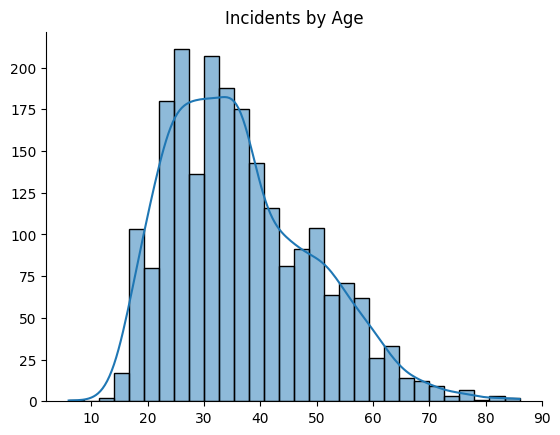

In [634]:
plot_histplot(police_data['Age'], 'Incidents by Age', '', '')

#### "Analysis"
- Our distribution has a big range of Ages, including ages from early 15s to late 80s.
- Most of the incidents are victims between their mid 20s to late 40s.
- The highest pick with more than 200 incidents can be seeing around late 20 years old. The reason behind this is unknown yet.
- We can also see that along line, the close it gets to older ages the tendency is to have less and less incidents.

Apparently, the age of victims has some effects on how they are treated during police calls.


### "By Gender"

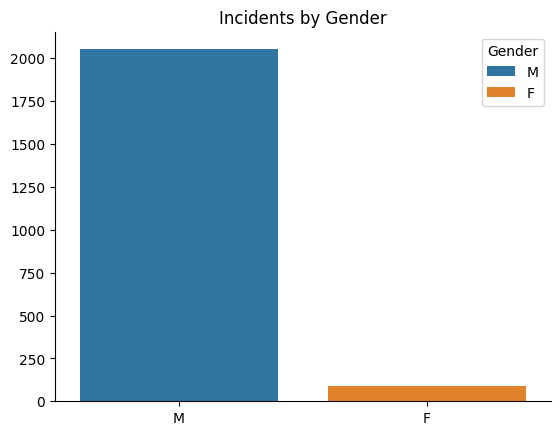

In [635]:
plot_countplot('Gender', police_data, 'Incidents by Gender', '', '', 'Gender')

#### "Analysis"
- The difference between Gender is enormous, in which Male victims have a substantial higher volume of incidents.
- Male victims have reached more than 2000 incidents, where Females didn't even get close to 500 incidents.

It's hard to tell why is that, but phisically saying Males tend to be stronger and use this to impose their dominace.


### "By Race"

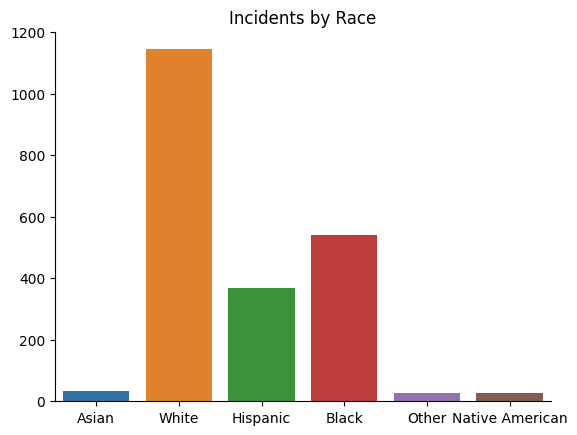

In [636]:
plot_countplot('Race', police_data, 'Incidents by Race', '', '', 'Race')

#### "Incidents by Race"
- The Dataframe presents 6 different races.
- The lowest incidents are caused on Asian, Native Americans and Other.
- The highest incidents are caused on White victims, Blacks being in second place and Hispanics in third.
- Combining the top 3 races, we have more than half of the incidents which it's scary to know.


### "Take aways"
- It's easy to see that white male victims are the highest number of incidents. However, it might be better distributed by ages, which we'll have to analyze more.
- Even tough white male victims has most of the incidents, black and hispanic males are right behind.
- We can also assume that female victims have a good approach to those incidents, just by comparing the genders.


## "Incidents Overview"

### "Threat Level"

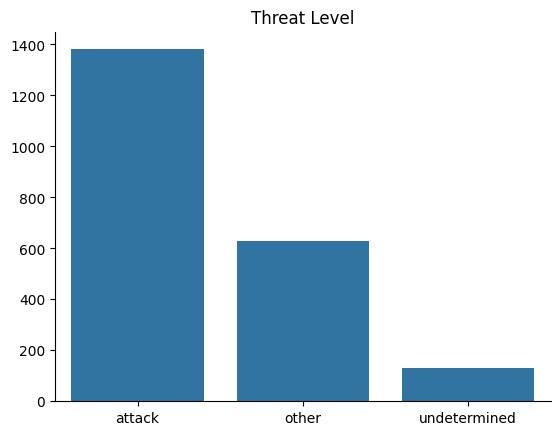

In [637]:
# Grouped Data
threat_level = police_data.groupby(by='Threat_level').count()['Victim']

plot_barplot(threat_level, 'Threat Level', '', '')

#### "Analysis"
- The majority of the incidents were by "attack". Which it might be a reason for conflicts.
- We can't determine what "Other" means, but there are still around 600 incidents.
- And a low percentage were "Undetermined".


### "Manner Of Death"

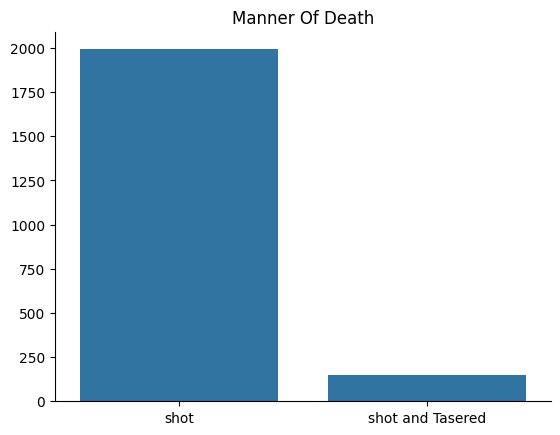

In [638]:
# Grouped Data
manner_of_death = police_data.groupby(by='Manner_of_death').count()['Victim']

plot_barplot(manner_of_death, 'Manner Of Death', '', '')

#### "Analysis"
- Basically, all the incidents the civilian was shot, or shot and tasered.


### "Flee"

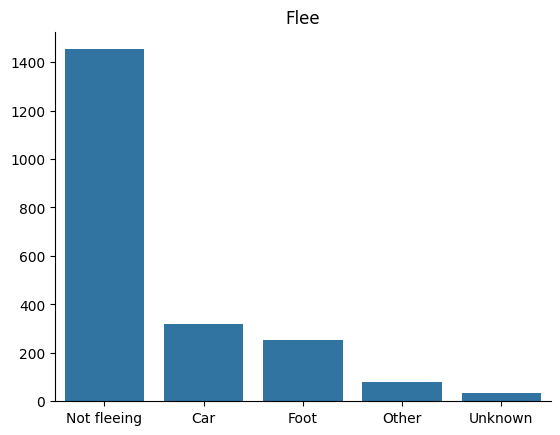

In [639]:
# Grouped Data
flee = police_data.groupby(by='Flee').count()[
    'Victim'].sort_values(ascending=False)

plot_barplot(flee, 'Flee', '', '')

#### "Analysis"
- This is where it gets interesting. Most of the incidents the victims were not trying to flee. They were actually involved in the conflict. Maybe the victim was not really a victim. There is a possibility of a crime being committed. So, maybe that's the reason why the data shows a high volume of incidents.


### "Weapons"

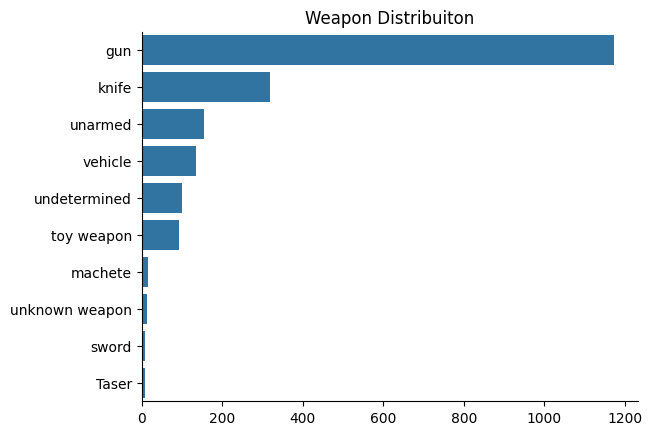

In [640]:
# Grouped Data
top_armed_categories = police_data.groupby(by='Armed').count(
).sort_values(by='Victim', ascending=False)['Victim'].head(10)

plot_barplot(top_armed_categories, 'Weapon Distribuiton', '', '', 'h')

#### "Analysis"
- This graph shows the Top10 weapons that the "victims" were using in the incident.
- We can see that "Gun" was the main weapon in 54.8% of the time.
- This might prove that the victims were actully causing a problem and they ended up dying for an understantable reason.


### "By State"

In [641]:
# Grouping Data
incident_counts = police_data.groupby(
    by='State').size().reset_index(name='IncidentCount')

map = folium_map_incidents(incident_counts)
map

#### "Analysis"
- If we take a closer look, we can see that the majority of the States have a low amount of incidents.
- The only three state that have more than 100 incidents are: Florida, Texas and California.

PS: This map is not taking into consideration a normalized percentage.


## "Body Camera Usage Overview"

### "Body Camera By Race and Male Gender"

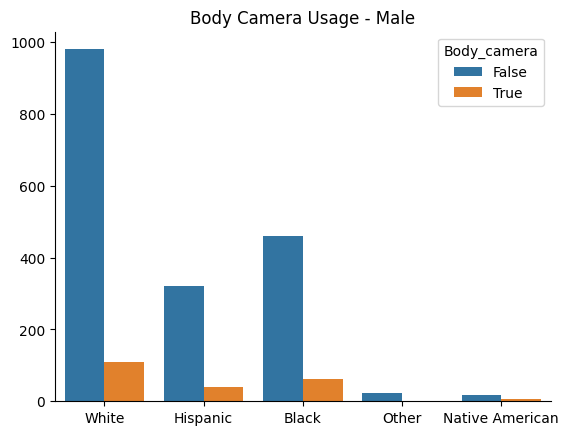

In [642]:
#Filtered Data
filtered_data = police_data[(police_data['Race'].isin(
    ['White', 'Black', 'Hispanic', 'Other', 'Native American'])) & (police_data['Gender'] == 'M')]

plot_countplot('Race', filtered_data, 'Body Camera Usage - Male', '', '', 'Body_camera')

#### "White"
- It's impressive that almost 1000 incidents involved White male victims with no camere usage.
- This represents almost 50% of all the incidents in the data.
- Unfortunetely, around 100 incidents still happened with camera usage.


#### "Hispanic"
- The data shows that around 300 didn't have camera usage. Which it's around 1/3 of White male victims.
- This represents around 15% of all the incidents.
- With the camera usage data, it drops significantly to less than 100 incidents.


#### "Black"
- It's also impressive that Black male victims reached around 500 incidents with no camera usage.
- It represents around 25% of all incidents.
- With camera usage, it also dropped to less than 100 incidents.


#### "Other"
- It's almost zero comparing to the other three races above.


#### "Native American"
- It's also almost zero comparing to the other races.


#### "Take aways"
- With this analysis, we can confirm that around 50% of all incidents are involving White male victims.
- Which it can make us realize that maybe there is a racial problematic on those incidents or tendency to react. It gets worse when there is no monitoring on the situation.
- However, if it's a racial persecution, we can't determine with the data because it doesn't show the status of the police officers.
- Based on these informations, camera usage makes a huge difference to prevent incidents between police officers and civilians.



### "White Male Victims - No Camera Usage"

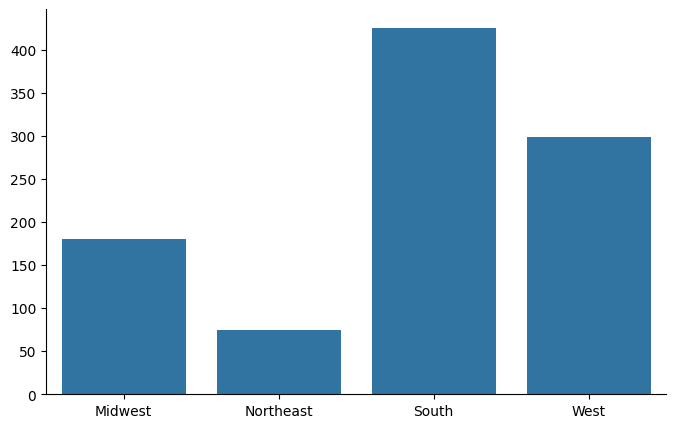

In [643]:
# Filtered and Group Data
filtered_incidents = police_data[(police_data['Race'] == 'White') & (police_data['Body_camera'] == False) & (
    police_data['Gender'] == 'M')].groupby('Region').size().reset_index(name='Incident Count')

fig, ax = plt.subplots(figsize=(8, 5))

sns.barplot(x='Region', y='Incident Count', data=filtered_incidents, ax=ax)
sns.despine()
plt.xlabel('')
plt.ylabel('')
plt.show()

#### "Analysis"
- According to the graphs, most of the incidents happen in the South, with more than 400 incidents, and West regions, with more than 300 incidents.
- Combining those 2 regions, it contains around 34% of all incidents. 
- So, 1/3 of the incidents are concentraded by White Male Victims with no Camera in the South and West region.
- However, it's still unknown the reason behind those many incidents in those 2 regions. Why is that ?
- As a matter of fact, we already know that the camera helps the victims. But, is there a racial or cultural reason for when there is no camera? Maybe a reason to escalate the conflicts when there is no one recording? 

### "White Male Victims - w/ Camera Usage"

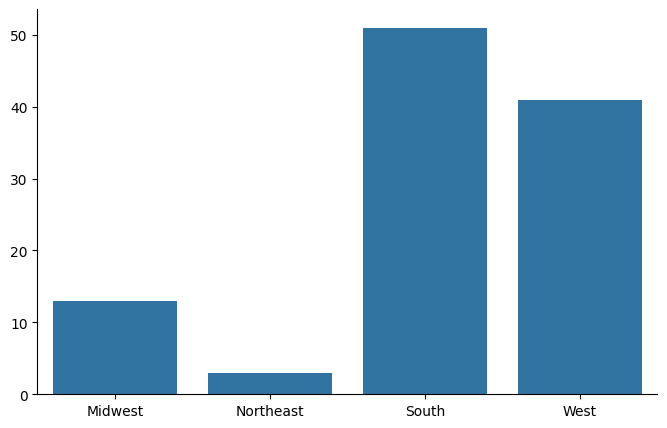

In [644]:
# Filtered and Group Data
filtered_incidents = police_data[(police_data['Race'] == 'White') & (police_data['Body_camera'] == True) & (
    police_data['Gender'] == 'M')].groupby('Region').size().reset_index(name='Incident Count')

fig, ax = plt.subplots(figsize=(8, 5))

sns.barplot(x='Region', y='Incident Count', data=filtered_incidents, ax=ax)
sns.despine()
plt.xlabel('')
plt.ylabel('')
plt.show()

#### "Analysis"
- The pattern is still the same, where South and West are at the top. However, with camera usage, we can confirm the decrease of incidents for almost lower than 50 in the South.
- Even the South region, has less than the lowest with no camera usage (Northeast).

### "Signs Of Mental Illness by Region - White Male No Camera Usage"

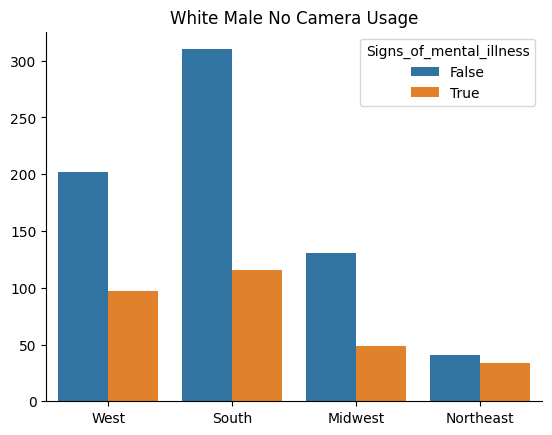

In [645]:
# Filtered Data
filtered_incidents = police_data[(police_data['Race'] == 'White') & (police_data['Gender'] == 'M') & (
    police_data['Body_camera'] == False) & (police_data['Region'].isin(['Midwest', 'Northeast', 'South', 'West']))]

plot_countplot('Region', filtered_incidents,
               'White Male No Camera Usage', '', '', 'Signs_of_mental_illness')

#### "Analysis"
- It's suprising that mental illness is not the main reason for having high incidents. Honestly, it's the opposite.
- The proportion between with an without "Signs of Mental Illness" in the "West" and "Midwest" are 1/3. Besides, the "Northeast" that it's almost the same proportion and the "South" is 1/2.

### "Signs Of Mental Illness by Region - White Male w/ Camera Usage"

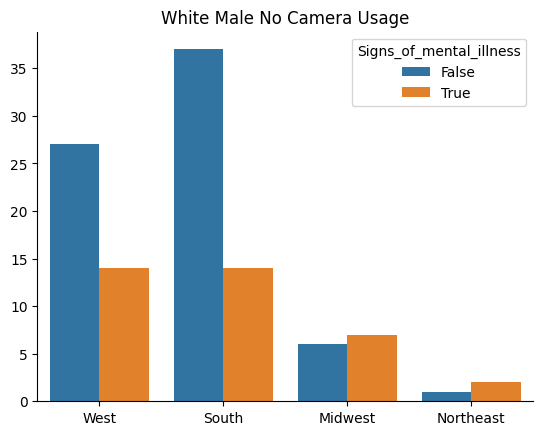

In [646]:
# Filtered Data
filtered_incidents = police_data[(police_data['Race'] == 'White') & (police_data['Gender'] == 'M') & (
    police_data['Body_camera'] == True) & (police_data['Region'].isin(['Midwest', 'Northeast', 'South', 'West']))]

plot_countplot('Region', filtered_incidents, 'White Male No Camera Usage', '', '', 'Signs_of_mental_illness')

#### "Analysis"
- The proportion are similar comparing with "No Camera Usage".
- The only difference is that in the regions of Midwest and Northeast, most incidents are caused by victims with "Signs of Mental Illness". Even if by a small quantity.

### "By State % - White Male No Camera Usage"

In [647]:
# Filtered Data
filtered_incidents = police_data[(police_data['Race'] == 'White') & (
    police_data['Body_camera'] == False) & (police_data['Gender'] == 'M')]

map = normalized_folium_map_incidents(filtered_incidents, 'State')
map

#### <font color='white'>"Analysis"
- This map shows a really interesting fact. Now that we have the incidents normalized by State, we can see the percentage of incidents with no camera.
- The highest percentage is found on California, with "56.92%" of incidents. Followed by Texas, Florida and Arizona.
- There is a big influence on the left party over California nowadays, which it can inflict directly on civilians taking advantege over the law to be able to steal and commit crimes. Because of the low capacity of the State to control the unbeatable freedom and not implement monitoring as a safety plan.
- For that reason, it would make sense why California has the highest incident rate comparing to other States.
</font>

### "By State % - w/ Camera Usage"

In [648]:
# Filtered Data
filtered_incidents = police_data[(police_data['Race'] == 'White') & (
    police_data['Body_camera'] == True) & (police_data['Gender'] == 'M')]

map = normalized_folium_map_incidents(filtered_incidents, 'State')
map

#### "Analysis"
- The highest percentage is found on Texas, with "43.36%" of incidents with camera. Followed by California, Alabama and Arizona.
- It makes a lot of sense for Texas being the highest one, because of the cultural influence on having guns and security plans.
- However, the combination of having guns and camera usage didn't decrease the percentage significantly. However, the number of incidents indeed decreased.
- Texas has a good monitoring over incidents. We can assume that, by the fact of having more monitoring over the situation, the safety of the State would be better. Almost 10% over California and Arizona.
- Even though the incident rate is high, the control over each incident would help to explain what happened instead of just saying that the Police is aggressive and has no trainning. 

## "Date Overview"

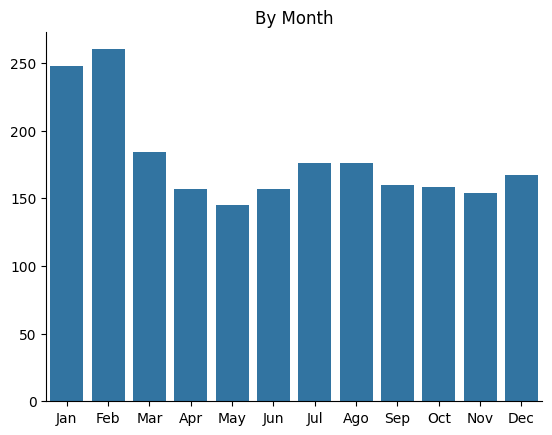

In [649]:
#Transfrom Date to Month
police_data['Date'] = pd.to_datetime(police_data['Date'])
police_data['Month'] = police_data['Date'].dt.month

#Groupby Month
grouped_df = police_data.groupby('Month').size().reset_index(name='Count')

#Dict for Months
month_acronyms = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May',
                  6: 'Jun', 7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

#Mapping Months
grouped_df['Month'] = grouped_df['Month'].map(month_acronyms)

#Setting Index as Months
grouped_df.set_index('Month', inplace=True)

#Ploting
sns.barplot(x=grouped_df.index, y='Count', data=grouped_df)
sns.despine()
plt.xlabel('')
plt.ylabel('')
plt.title('By Month')
plt.show()

#### "Analysis"
- This graph is to show if there is any big difference between the periods when incidents happen. However, the distribuiton is well balanced.
- The only difference between the other months are in "January" and "February".
- That difference might exist, because it's winter time. So, less police officers in the street guaranteeing safety and there is a higher chance of crimes or conflits to happen.

## "Conclusion"

### "Demographic"

####
- Based on the Demographics, we found that a specific profile with higher incidents counts.
- Profile: White, Male and Age between 20 and 45 years old.

### "Incidents"

####
- Most of the incidents were by civilians "Attacking". Which it means they were causing a conflict.
- The majority of the manner of death were caused by a "Shot".
- Also the majaority of the civilians were "Not Fleeing" from the conflict. They were actually involved into the situation.
- And the main States that have dominace over the others are California, Texas, Florida and Arizona.

### "Body Camera Usage"

#### The Body Camera Usage plays a big role into this analysis.
- First, we found that in most incidents the camera were not being used, specially on White Males.
- Then, we were able to detect the region for the same parameters. Which it shows a congruence with the Demographic analysis. Where South and West were the top regions.
- So we dove into Analyzing the Mental State of the civilians by Region. And we could conclude that, most of the incidents on those main regions were caused by people that didn't have any "Signs of Mental Illness". It shows that there were an intentional reason behind the incident.
- And to deeply verify which state has most of the incidents, the data shows to be correct. Where the states of California, Texas, Florida and Arizona have the most incidents with no camera usage.

### "Date"

####
- We didn't find a big reason behind the dates. However, there is a bit difference between "January" and "February". Which it might be caused by the winter season. Because of that, the monitoring during this moment of the year might be lower comparing to the other periods. And by that, it can cause a slight difference.

### "Final Analysis"

#### There are some cenarios to be considered, but this analysis shows an expressive data to a certain population and their intetions.
- The majority of the cases are caused by White Male civilians during incidents where there were no monitoring (No Camera Usage) in the South and West regions.
- Apparently that profile has a higher chance to caused problems to the safety of others, because the data shows that a high percentage of them were armed and didn't having any mental illness to explain why they were attacking.
- In addition to that, the high percentage rate of those regions mentioned above tend to be more radical when we talk about rights and freedom. And that can play a big role when causing incidents in the society, which it explains why there is a big amount of deaths.

By taking all of these into consideration, we can get to the point where those incidents are caused by a society that doesn't have enough control over conflits. Not enough monitoring and a high freedom to contain weapons in their possesion.

Maybe the solution would be to increase the monitoring and create a more complex and harder system for people to buy weapons. Specially for the profile we encounter on the data.